# Relu in the last conv2d layer and shape (56 x 56 x 3)

In [1]:
# GPU info
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install -q gputil
!pip install -q psutil
!pip install -q humanize
import psutil as ps # library for retrieving information on running processes and system utilization
import humanize as hm # library for turning a number into a fuzzy human-readable
import os # library for operations with operation system 
import GPUtil as GPU # access to GPU subsystem
GPUs = GPU.getGPUs() # get number of GPUs
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
process = ps.Process(os.getpid())
print(f'Gen RAM Free: {hm.naturalsize( ps.virtual_memory().available )} | Proc size: {hm.naturalsize( process.memory_info().rss )}')
print( 'GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util: {2:3.0f}% | Total: {3:.0f}MB'.format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
print(f'GPU Model: {gpu.name}')

Gen RAM Free: 12.5 GB | Proc size: 95.3 MB
GPU RAM Free: 16280MB | Used: 0MB | Util:   0% | Total: 16280MB
GPU Model: Tesla P100-PCIE-16GB


In [2]:
# Keras's libraries
from tensorflow.keras.models import Model, Sequential, load_model # models
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, Reshape, Input, Conv2DTranspose, Activation, concatenate # Layers
from tensorflow.compat.v1.keras.preprocessing.image import ImageDataGenerator # Load and augmentation
from tensorflow.keras.optimizers import Adam, Adadelta, SGD # Optimizers
from tensorflow.keras import utils # Utils for converting to One Hot-Encoding
from tensorflow.keras.utils import plot_model # Draw model
from tensorflow.keras.preprocessing import image # Load images
from tensorflow.keras.callbacks import LambdaCallback, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau # Callbacks

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay # Metrics

import numpy as np # Working with arrays
import matplotlib.pyplot as plt # For charts
# from PIL import Image # Load images
import random # Random library
import math # Math functions
import os # File system utils
import gdown # Load files from web

# Draw charts in the same windows
%matplotlib inline



In [3]:
# Colab filesystem
from google.colab import files 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Unpack files
# !unzip -q -o '/content/drive/MyDrive/archive.zip' -d /content
!unzip -q -o '/content/drive/MyDrive/classification.zip' -d /content

In [5]:
# Look at the dirs
!ls /content/train
!ls /content/test

bag  bal  ban  bea  can  env  gbt  mon	pbt  toy
bag  bal  ban  bea  can  env  gbt  mon	pbt  toy


In [6]:
# Hyperparameters
TRAIN_PATH  = '/content/train'  # Our source files
TEST_PATH   = '/content/test'   # Here we will drop test set

TEST_SPLIT  = 0.2 # 20% for test data
VAL_SPLIT   = 0.2 # 20% for validation data 

IMG_WIDTH   = 56 # 224 # Image width for neural network
IMG_HEIGHT  = 56 # 224 # Image height for neural network

BATCH_SIZE    = 256                        # Batch size for training
OPTIMIZER     = Adam(learning_rate=1e-6)  # Optimizer
EPOCHS        = 100                       # Epochs

# Augmentation parameters
ROTATION_RANGE      = 8     # Degree range for random rotations
WIDTH_SHIFT_RANGE   = 0.2   # Horizontal shift limit up to %
HEIGHT_SHIFT_RANGE  = 0.2   # Vertical shift limit up to %
ZOOM_RANGE          = 0.15  # [1-zoom_range, 1+zoom_range]
BRIGHTNESS_RANGE    = (0.7, 1.3)  #  Range for picking a brightness shift value from
HORIZONTAL_FLIP     = True  # Randomly flip inputs horizontally

In [7]:
# A list of class names
CLASS_LIST = sorted(os.listdir(TRAIN_PATH)) # Assign number for each class by sorting the set of classes

# Number of classes
CLASS_COUNT = len(CLASS_LIST)

print(f'Labels: {CLASS_LIST}\nNumber of classes: {CLASS_COUNT}')

Labels: ['bag', 'bal', 'ban', 'bea', 'can', 'env', 'gbt', 'mon', 'pbt', 'toy']
Number of classes: 10


In [8]:
# # Dividing the complete dataset into training and test sets
# os.mkdir(TEST_PATH) # Folder for test data
# total_count = 0
# test_count = 0

# for class_name in CLASS_LIST:
#   class_path  = f'{TRAIN_PATH}/{class_name}'  # Full train dir path of the current class
#   test_path   = f'{TEST_PATH}/{class_name}'   # Full test dir path for the current class
#   class_files = os.listdir(class_path)        # A list of train images in the current class
#   class_file_count = len(class_files)         # Total number of images in the current class folder
#   os.mkdir(test_path)                         # Make a folder for the current test class images
#   test_file_count = int(class_file_count*TEST_SPLIT) # The number of test data images from the current class
#   random.shuffle(class_files)                 # Shuffle list of images in the current class
#   test_files = class_files[:test_file_count]  # A list of test images in the current class
#   for f in test_files:                        # Move test data images into new folder for test data for the current class
#     os.rename(f'{class_path}/{f}', f'{test_path}/{f}')
#   total_count += class_file_count             # Increase counter for total images
#   test_count += test_file_count               # Increase counter for test images
#   print(f'Class: {class_name}, Total:{class_file_count}, Test data: {test_file_count}')

# print(f'Total data: {total_count}, train data: {total_count-test_count}, test data: {test_count}')

In [9]:
# Image Generators
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=ROTATION_RANGE,
    width_shift_range=WIDTH_SHIFT_RANGE,
    height_shift_range=HEIGHT_SHIFT_RANGE,
    zoom_range=ZOOM_RANGE,
    brightness_range=BRIGHTNESS_RANGE,
    horizontal_flip=HORIZONTAL_FLIP,
    validation_split=VAL_SPLIT,
    # preprocessing_function=preprocess_input, # preprocess image
    )

validation_datagen = ImageDataGenerator(
    rescale=1. / 255,
    validation_split=VAL_SPLIT,
    # preprocessing_function=preprocess_input, # preprocess image
    )

test_datagen = ImageDataGenerator(
    rescale=1. / 255,
    # preprocessing_function=preprocess_input, # preprocess image
    )

In [10]:
# Data generator for training
train_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
    )

# Data generator for validation
validation_generator = validation_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
    )

# Data generator for testing
test_generator = test_datagen.flow_from_directory(
    TEST_PATH,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
    )

Found 47874 images belonging to 10 classes.
Found 11964 images belonging to 10 classes.
Found 14954 images belonging to 10 classes.


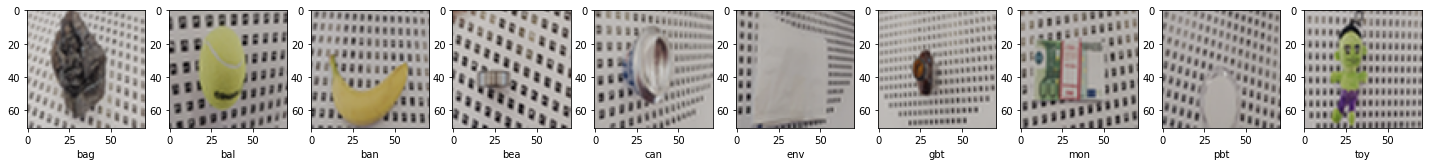

In [11]:
# Look at the random images from each class
fig, axs = plt.subplots(1, CLASS_COUNT, figsize=(25, 5))                   
for i in range(CLASS_COUNT):  # For each class
  class_path = TRAIN_PATH + '/' + CLASS_LIST[i]                                            
  images_list = os.listdir(class_path)
  image_path = class_path + '/' + random.choice(images_list)
  axs[i].imshow(image.load_img(image_path, target_size=(71, 71)))
  axs[i].set_xlabel(CLASS_LIST[i])
plt.show()

In [12]:
# Callbacks
checkpoint = [
             ModelCheckpoint('/content/drive/MyDrive/6_mymodelV3_dense512.h5', 
             monitor='val_loss', 
             save_best_only=True)
             ]
early = EarlyStopping(monitor='val_loss', patience=5, mode='auto')
lr_reduce = ReduceLROnPlateau(
                           monitor='val_loss',
                           patience=5, # 4
                           verbose=0, 
                           mode='auto'
                           )

In [13]:
# Function of training and evaluation
def train_model(model,
                train_data,
                val_data):
  
  # Model compilation
  model.compile(loss='categorical_crossentropy', optimizer=OPTIMIZER, metrics=['accuracy'])

  # Model train
  history = model.fit(train_data,
                      steps_per_epoch = train_data.samples // BATCH_SIZE,
                      validation_data=val_data,
                      validation_steps = val_data.samples // BATCH_SIZE,
                      epochs=EPOCHS,
                      # batch_size=BATCH_SIZE,
                      callbacks=[early,checkpoint,lr_reduce])

  # Visualization of the training process
  plt.plot(history.history['accuracy'], label='Part of the right answers on the training set')
  plt.plot(history.history['val_accuracy'], label='Part of the right answers on the validation set')
  plt.xlabel('Epoch of the training')
  plt.ylabel('Part of the right answers')
  plt.legend()
  plt.show()

# Function for evaluating model
def eval_model(model,
               x,
               y,
               class_labels=CLASS_LIST, 
               title='classification'):
  
  # Model compilation
  model.compile(loss='categorical_crossentropy', optimizer=OPTIMIZER, metrics=['accuracy'])

  # Model prediction
  y_pred = model.predict(x) # x_test
  y_true = y                # y_test

  # Confusion matrix
  cm = confusion_matrix(np.argmax(y_true, axis=1),
                        np.argmax(y_pred, axis=1),
                        normalize='true')
  cm = np.around(cm, 2)

  # Graph of confusion matrix
  fig, ax = plt.subplots(figsize=(10,10))
  ax.set_title(f'Neural network {title}: normilized confusion matrix', fontsize=18)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
  disp.plot(ax=ax)
  ax.images[-1].colorbar.remove()      
  fig.autofmt_xdate(rotation=90)        
  plt.xlabel('Predicted classes', fontsize=16)
  plt.ylabel('Actual classes', fontsize=16)
  plt.show()    

  print('-'*100)
  print(f'Neural network: {title}')

  # For each class:
  for cls in range(len(class_labels)):
      # The index of the class with the maximum prediction (confidence) value 
      cls_pred = np.argmax(cm[cls])
      # A message about the correctness or incorrectness of the prediction
      msg = 'Correct' if cls_pred == cls else 'Incorrect'
      # Text message about predicted class
      print('Class: {:<20} {:3.0f}% neural network predicted as a class {:<20} - {}'.format(class_labels[cls],
                                                                              100. * cm[cls, cls_pred],
                                                                              class_labels[cls_pred],
                                                                              msg))

  # The average recognition accuracy ( the average of the diagonal elements of the error matrix)
  print('\nThe average recognition accuracy: {:3.0f}%'.format(100. * cm.diagonal().mean()))


Loading the model is complete.
Number of layers: 65
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 56, 56, 3)]  0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 56, 56, 64)   1792        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 56, 56, 64)  256         ['block1_conv1[0][0]']           
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 56

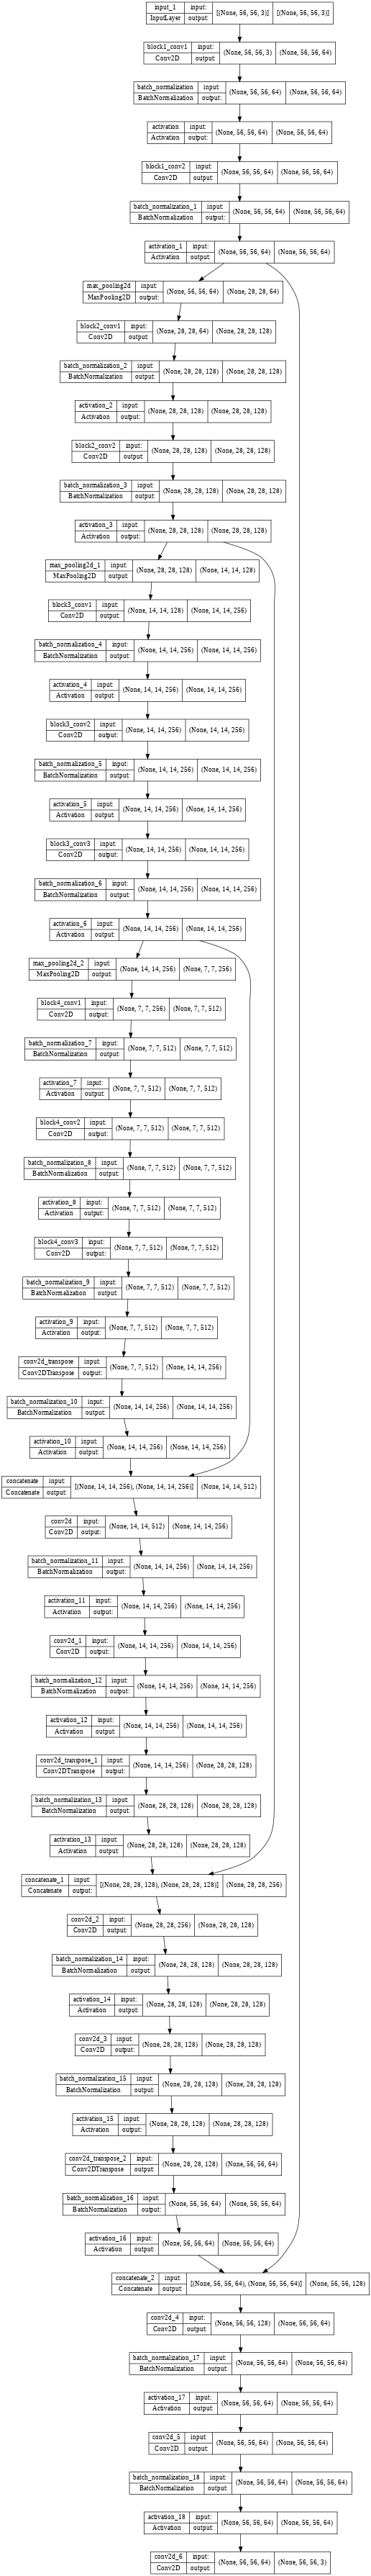

In [14]:
# Creating a neural network
img_input = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3)) # (56 x 56 x 3)

# Block 1 
x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input) 
x = BatchNormalization()(x)                                            
x = Activation('relu')(x)                                              

x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)         
x = BatchNormalization()(x)                                            
# (56 x 56)
block_1_out1= Activation('relu')(x)                                    

x = MaxPooling2D()(block_1_out1) # (56 x 56) -> (28 x 28)                                       

# Block 2 
x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)        
x = BatchNormalization()(x)                                            
x = Activation('relu')(x)                                              

x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)        
x = BatchNormalization()(x)                                            
# (28 x 28)
block_2_out1 = Activation('relu')(x)                                   

x = MaxPooling2D()(block_2_out1) # (28 x 28) -> (14 x 14)                                       

# Block 3 
x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)       
x = BatchNormalization()(x)                                            
x = Activation('relu')(x)                                              

x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)       
x = BatchNormalization()(x)                                            
x = Activation('relu')(x)                                              

x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)        
x = BatchNormalization()(x)                                            
# (14 x 14)
block_3_out1 = Activation('relu')(x)                                   

x = MaxPooling2D()(block_3_out1) # (14 x 14) -> (7 x 7)                                       

# Block 4 - Bottom Line
x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)        
x = BatchNormalization()(x)                                            
x = Activation('relu')(x)                                              

x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)        
x = BatchNormalization()(x)                                            
x = Activation('relu')(x)                                              

x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)        
x = BatchNormalization()(x)                                            
# (7 x 7)
block_4_out1 = Activation('relu')(x)                                   
x = block_4_out1 

# UP to 3
x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x) # (7 x 7) -> (14 x 14)   
x = BatchNormalization()(x)                                            
x = Activation('relu')(x)                                              

# (14 x 14)
x = concatenate([x, block_3_out1])                                      
x = Conv2D(256, (3, 3), padding='same')(x)                             
x = BatchNormalization()(x)                                            
x = Activation('relu')(x)                                              

x = Conv2D(256, (3, 3), padding='same')(x)
x = BatchNormalization()(x)                                            
x = Activation('relu')(x)                                              

# UP to 2
x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x) # (14 x 14) -> (28 x 28)  
x = BatchNormalization()(x)                                            
x = Activation('relu')(x)                                              

# (28 x 28)
x = concatenate([x, block_2_out1])                                      
x = Conv2D(128, (3, 3), padding='same')(x)                             
x = BatchNormalization()(x)                                            
x = Activation('relu')(x)                                              

x = Conv2D(128, (3, 3), padding='same')(x) 
x = BatchNormalization()(x) 
x = Activation('relu')(x) 

# UP to 1
x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x) # (28 x 28) -> (56 x 56)
x = BatchNormalization()(x) 
x = Activation('relu')(x) 

# (56 x 56)
x = concatenate([x, block_1_out1])  
x = Conv2D(64, (3, 3), padding='same')(x) 
x = BatchNormalization()(x) 
x = Activation('relu')(x) 

x = Conv2D(64, (3, 3), padding='same')(x) 
x = BatchNormalization()(x) 
x = Activation('relu')(x) 

x = Conv2D(3, (3, 3), activation='relu', padding='same')(x) # (56 x 56 x 3) 

mymodel = Model(img_input, x) # Creating the base model

print(f'\nLoading the model is complete.\nNumber of layers: {len(mymodel.layers)}')

mymodel.summary()

print()

plot_model(mymodel, dpi=48, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 56, 56, 3)         10665027  
                                                                 
 flatten (Flatten)           (None, 9408)              0         
                                                                 
 dense (Dense)               (None, 512)               4817408   
                                                                 
 dense_1 (Dense)             (None, 10)                5130      
                                                                 
Total params: 15,487,565
Trainable params: 15,479,501
Non-trainable params: 8,064
_________________________________________________________________


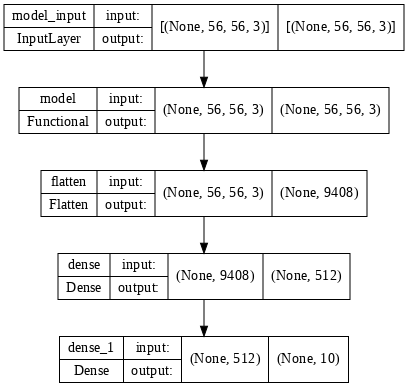

In [15]:
# Creating a composite neural network
model = Sequential()
model.add(mymodel)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.1))  
model.add(Dense(CLASS_COUNT, activation='softmax'))

model.summary()
plot_model(model, dpi=72, show_shapes=True)

Epoch 1/100
187/187 [==============================] - 117s 547ms/step - loss: 0.9465 - accuracy: 0.6752 - val_loss: 2.2948 - val_accuracy: 0.1030 - lr: 0.0010
Epoch 2/100
187/187 [==============================] - 101s 542ms/step - loss: 0.2829 - accuracy: 0.9096 - val_loss: 3.1583 - val_accuracy: 0.2384 - lr: 0.0010
Epoch 3/100
187/187 [==============================] - 100s 536ms/step - loss: 0.1389 - accuracy: 0.9555 - val_loss: 2.7654 - val_accuracy: 0.4576 - lr: 0.0010
Epoch 4/100
187/187 [==============================] - 102s 543ms/step - loss: 0.0703 - accuracy: 0.9782 - val_loss: 0.2137 - val_accuracy: 0.9425 - lr: 0.0010
Epoch 5/100
187/187 [==============================] - 104s 558ms/step - loss: 0.0348 - accuracy: 0.9896 - val_loss: 0.2781 - val_accuracy: 0.8997 - lr: 0.0010
Epoch 6/100
187/187 [==============================] - 100s 533ms/step - loss: 0.2366 - accuracy: 0.9229 - val_loss: 7.1273 - val_accuracy: 0.1683 - lr: 0.0010
Epoch 7/100
187/187 [===================

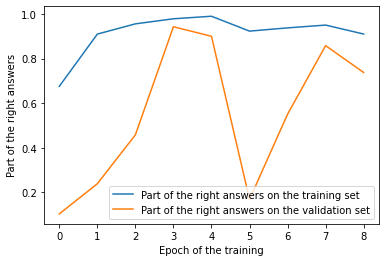

In [16]:
# processing errors with truncated images
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Hyperparameters
BATCH_SIZE    = 256                        # Batch size for training
OPTIMIZER     = Adam(learning_rate=1e-3)  # Optimizer
EPOCHS        = 100                       # Epochs

# Training of the model
train_model(model, 
            train_generator, 
            validation_generator)

In [17]:
# Load last weights
model.load_weights('/content/drive/MyDrive/6_mymodelV3_dense512.h5')
# model = load_model('/content/drive/MyDrive/6_mymodelV3_dense512.h5', compile = True)

Epoch 1/100
187/187 [==============================] - 102s 534ms/step - loss: 0.0212 - accuracy: 0.9937 - val_loss: 0.2365 - val_accuracy: 0.9617 - lr: 1.0000e-04
Epoch 2/100
187/187 [==============================] - 100s 534ms/step - loss: 0.0159 - accuracy: 0.9952 - val_loss: 0.2124 - val_accuracy: 0.9649 - lr: 1.0000e-04
Epoch 3/100
187/187 [==============================] - 101s 541ms/step - loss: 0.0215 - accuracy: 0.9926 - val_loss: 0.1295 - val_accuracy: 0.9610 - lr: 1.0000e-04
Epoch 4/100
187/187 [==============================] - 102s 544ms/step - loss: 0.0097 - accuracy: 0.9972 - val_loss: 0.1125 - val_accuracy: 0.9710 - lr: 1.0000e-04
Epoch 5/100
187/187 [==============================] - 100s 532ms/step - loss: 0.0069 - accuracy: 0.9978 - val_loss: 0.1248 - val_accuracy: 0.9709 - lr: 1.0000e-04
Epoch 6/100
187/187 [==============================] - 101s 540ms/step - loss: 0.0493 - accuracy: 0.9861 - val_loss: 0.0589 - val_accuracy: 0.9811 - lr: 1.0000e-04
Epoch 7/100
187/

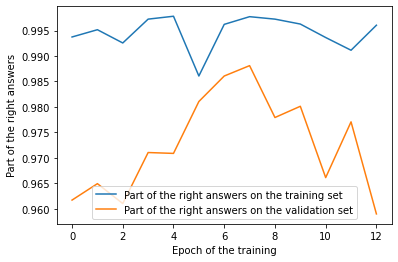

In [18]:
# processing errors with truncated images
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Hyperparameters
BATCH_SIZE    = 256                        # Batch size for training
OPTIMIZER     = Adam(learning_rate=1e-4)  # Optimizer
EPOCHS        = 100                       # Epochs

# Training of the model
train_model(model, 
            train_generator, 
            validation_generator)

In [19]:
# Load last weights
model.load_weights('/content/drive/MyDrive/6_mymodelV3_dense512.h5')
# model = load_model('/content/drive/MyDrive/6_mymodelV3_dense512.h5', compile = True)

Epoch 1/100
187/187 [==============================] - 103s 541ms/step - loss: 0.0061 - accuracy: 0.9982 - val_loss: 0.0387 - val_accuracy: 0.9854 - lr: 1.0000e-05
Epoch 2/100
187/187 [==============================] - 102s 546ms/step - loss: 0.0053 - accuracy: 0.9983 - val_loss: 0.0411 - val_accuracy: 0.9854 - lr: 1.0000e-05
Epoch 3/100
187/187 [==============================] - 102s 545ms/step - loss: 0.0058 - accuracy: 0.9984 - val_loss: 0.0555 - val_accuracy: 0.9819 - lr: 1.0000e-05
Epoch 4/100
187/187 [==============================] - 101s 539ms/step - loss: 0.0062 - accuracy: 0.9981 - val_loss: 0.0797 - val_accuracy: 0.9762 - lr: 1.0000e-05
Epoch 5/100
187/187 [==============================] - 101s 536ms/step - loss: 0.0056 - accuracy: 0.9982 - val_loss: 0.0561 - val_accuracy: 0.9818 - lr: 1.0000e-05
Epoch 6/100
187/187 [==============================] - 101s 538ms/step - loss: 0.0047 - accuracy: 0.9985 - val_loss: 0.0476 - val_accuracy: 0.9842 - lr: 1.0000e-05


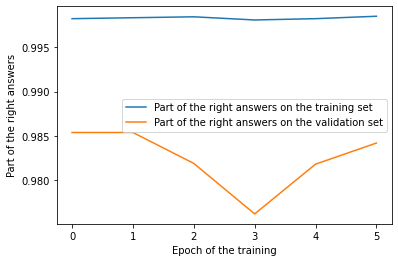

In [20]:
# processing errors with truncated images
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Hyperparameters
BATCH_SIZE    = 256                        # Batch size for training
OPTIMIZER     = Adam(learning_rate=1e-5)  # Optimizer
EPOCHS        = 100                       # Epochs

# Training of the model
train_model(model, 
            train_generator, 
            validation_generator)

In [21]:
# Load last weights
model.load_weights('/content/drive/MyDrive/6_mymodelV3_dense512.h5')
# model = load_model('/content/drive/MyDrive/6_mymodelV3_dense512.h5', compile = True)

Epoch 1/100
187/187 [==============================] - 106s 557ms/step - loss: 0.0067 - accuracy: 0.9979 - val_loss: 0.0404 - val_accuracy: 0.9865 - lr: 1.0000e-07
Epoch 2/100
187/187 [==============================] - 100s 535ms/step - loss: 0.0065 - accuracy: 0.9980 - val_loss: 0.0422 - val_accuracy: 0.9859 - lr: 1.0000e-07
Epoch 3/100
187/187 [==============================] - 100s 535ms/step - loss: 0.0075 - accuracy: 0.9979 - val_loss: 0.0421 - val_accuracy: 0.9858 - lr: 1.0000e-07
Epoch 4/100
187/187 [==============================] - 100s 535ms/step - loss: 0.0081 - accuracy: 0.9978 - val_loss: 0.0415 - val_accuracy: 0.9861 - lr: 1.0000e-07
Epoch 5/100
187/187 [==============================] - 100s 535ms/step - loss: 0.0070 - accuracy: 0.9977 - val_loss: 0.0396 - val_accuracy: 0.9865 - lr: 1.0000e-07
Epoch 6/100
187/187 [==============================] - 100s 533ms/step - loss: 0.0077 - accuracy: 0.9979 - val_loss: 0.0392 - val_accuracy: 0.9867 - lr: 1.0000e-07
Epoch 7/100
187/

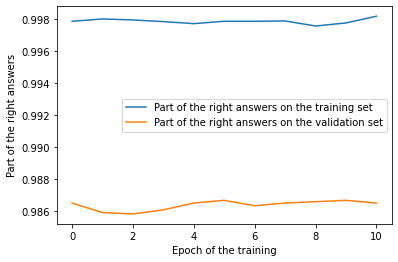

In [22]:
# processing errors with truncated images
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Hyperparameters
BATCH_SIZE    = 256                        # Batch size for training
OPTIMIZER     = Adam(learning_rate=1e-7)  # Optimizer
EPOCHS        = 100                       # Epochs

# Training of the model
train_model(model, 
            train_generator, 
            validation_generator)

In [23]:
# Load last weights
model.load_weights('/content/drive/MyDrive/6_mymodelV3_dense512.h5')
# model = load_model('/content/drive/MyDrive/6_mymodelV3_dense512.h5', compile = True)

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 56, 56, 3)         10665027  
                                                                 
 flatten (Flatten)           (None, 9408)              0         
                                                                 
 dense (Dense)               (None, 512)               4817408   
                                                                 
 dense_1 (Dense)             (None, 10)                5130      
                                                                 
Total params: 15,487,565
Trainable params: 15,479,501
Non-trainable params: 8,064
_________________________________________________________________


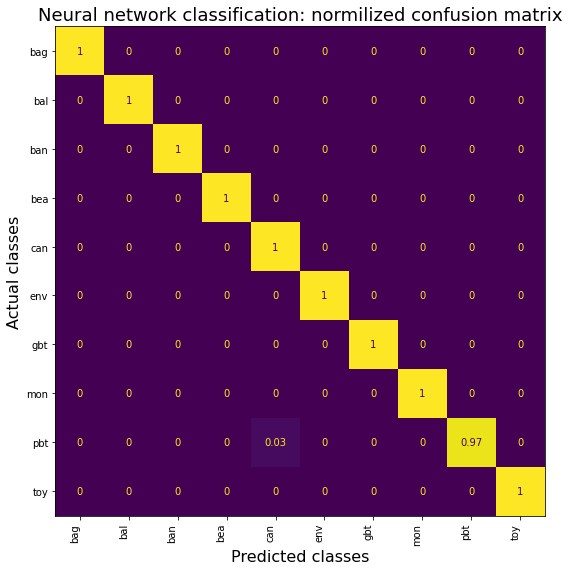

----------------------------------------------------------------------------------------------------
Neural network: classification
Class: bag                  100% neural network predicted as a class bag                  - Correct
Class: bal                  100% neural network predicted as a class bal                  - Correct
Class: ban                  100% neural network predicted as a class ban                  - Correct
Class: bea                  100% neural network predicted as a class bea                  - Correct
Class: can                  100% neural network predicted as a class can                  - Correct
Class: env                  100% neural network predicted as a class env                  - Correct
Class: gbt                  100% neural network predicted as a class gbt                  - Correct
Class: mon                  100% neural network predicted as a class mon                  - Correct
Class: pbt                   97% neural network predicted as a class

In [25]:
# Evaluating of the model
eval_model(model,
           test_generator[0][0], 
           test_generator[0][1])

In [26]:
# classes in test_generator
list(test_generator.class_indices)

['bag', 'bal', 'ban', 'bea', 'can', 'env', 'gbt', 'mon', 'pbt', 'toy']

In [27]:
# garbage collection
import gc    
gc.collect()

14985

In [28]:
# Load test data from directories
from PIL import ImageFile # Load images
ImageFile.LOAD_TRUNCATED_IMAGES = True # Load truncated images

x_test = [] # here we will put x for test data
y_test = [] # he we will put labels for test data

MAX_FILES_COUNT = 1000 # Limits the number of files in test data to save memory 

CLASS_LIST = list(test_generator.class_indices) # get class label from generator
CLASS_COUNT = len(CLASS_LIST) # count of classes from generator
for class_id, class_name in enumerate(CLASS_LIST):  # For each class
  class_path = TEST_PATH + '/' + class_name # path to current class
  file_list = os.listdir(class_path)
  random.shuffle(file_list) # Shuffle list of files in the current class
  for file_name in file_list[:MAX_FILES_COUNT]: # for each filename in class directory
    image_path = class_path + '/' + file_name # path to current image
    img = image.load_img(image_path, target_size=(IMG_WIDTH, IMG_HEIGHT)) # current image
    x = image.img_to_array(img) # the image as an array
    y = utils.to_categorical(class_id, CLASS_COUNT) # current label to One Hot Encoding
    x_test.append(x) # append x
    y_test.append(y) # append y

x_test = np.array(x_test) # convert to numpy array
x_test = x_test.astype('float32') / 255 # preprocess images
y_test = np.array(y_test) # convert to numpy array
print(x_test.shape)
print(y_test.shape)

(8515, 56, 56, 3)
(8515, 10)


In [29]:
# Evaluating with the origin test files
model.compile(loss='categorical_crossentropy', optimizer=OPTIMIZER, metrics=['accuracy']) # compile the model
scores = model.evaluate(x_test, y_test, verbose=0) # evaluating the model
print('\nPercent of the right answers on the test data: {:.2%}\n'\
      .format(scores[1]))


Percent of the right answers on the test data: 99.33%



In [30]:
# # Final accuracy for test data
# # scores[0] - loss
# # scores[1] - percents of correct answers

# # Model compilation
# model.compile(loss='categorical_crossentropy', optimizer=OPTIMIZER, metrics=['accuracy'])
# scores = model.evaluate(test_generator[0][0], test_generator[0][1], verbose=0)  
# print('\nPercent of the right answers on the test data: {:.2%}\n'\
#       .format(scores[1]))

In [31]:
# garbage collection
import gc    
gc.collect()

873

In [32]:
# Evaluating currency of prediction test data for each class
total_currency = 0 # total currency for all classes
CLASS_LIST = list(train_generator.class_indices) # list of classes from generator
CLASS_COUNT = len(CLASS_LIST) # quantity of classes
y_train_labels = np.argmax(y_test, axis=1) # get labels from y_test without One Hot Encoding
# print(CLASS_LIST)
# print(CLASS_COUNT)

for class_id, class_name in enumerate(CLASS_LIST):  # For each class
  cur_ids = np.where(y_train_labels==class_id)[0] # indexes of samples in y_test that belong to current class class_id 
  total_labels_count = cur_ids.shape[0] # quantity of labels belongs to current class
  pred_labels = np.argmax( model.predict(x_test[cur_ids]) , axis=1) # labels after predict with current class
  correct_labels_count = np.where(pred_labels==class_id)[0].shape[0] # quantity labels after predict that belongs to current class
  cur_currency = correct_labels_count/total_labels_count # part of right predicted labels from all labels for current class
  total_currency += cur_currency # adjust total currency for all classes
  print(f'Class {class_name} recognized at {round(cur_currency, 2)*100}% \t: {correct_labels_count} \tfrom {total_labels_count}')

print(f'Total currency is {round(total_currency/CLASS_COUNT*100, 2)}%')

Class bag recognized at 98.0% 	: 963 	from 987
Class bal recognized at 100.0% 	: 1000 	from 1000
Class ban recognized at 100.0% 	: 547 	from 547
Class bea recognized at 100.0% 	: 1000 	from 1000
Class can recognized at 99.0% 	: 989 	from 1000
Class env recognized at 100.0% 	: 416 	from 418
Class gbt recognized at 100.0% 	: 563 	from 563
Class mon recognized at 100.0% 	: 1000 	from 1000
Class pbt recognized at 98.0% 	: 980 	from 1000
Class toy recognized at 100.0% 	: 1000 	from 1000
Total currency is 99.4%


In [33]:
# Function for getting size of a model in memory
# import tensorflow as tf 
def get_model_memory_usage(batch_size, model):
    import numpy as np
    try:
        from keras import backend as K
    except:
        from tensorflow.keras import backend as K

    shapes_mem_count = 0
    internal_model_mem_count = 0
    for l in model.layers:
        layer_type = l.__class__.__name__
        if layer_type == 'Model':
            internal_model_mem_count += get_model_memory_usage(batch_size, l)
        single_layer_mem = 1
        out_shape = l.output_shape
        if type(out_shape) is list:
            out_shape = out_shape[0]
        for s in out_shape:
            if s is None:
                continue
            single_layer_mem *= s
        shapes_mem_count += single_layer_mem

    trainable_count = np.sum([K.count_params(p) for p in model.trainable_weights])
    non_trainable_count = np.sum([K.count_params(p) for p in model.non_trainable_weights])

    number_size = 4.0
    if K.floatx() == 'float16':
        number_size = 2.0
    if K.floatx() == 'float64':
        number_size = 8.0

    total_memory = number_size * (batch_size * shapes_mem_count + trainable_count + non_trainable_count)
    gbytes = np.round(total_memory / (1024.0 ** 3), 3) + internal_model_mem_count
    return gbytes

In [34]:
# Total amount memory ocuppied by the model
print(get_model_memory_usage(BATCH_SIZE, model), 'Gbytes')

0.076 Gbytes


In [ ]:
# First sample from test_generator with batch dimension
test_generator[0][0][0][None,...].shape

(1, 56, 56, 3)

In [ ]:
# Prediction of the first sample without batch dimension
pred = mymodel.predict(test_generator[0][0][0][None,...]) # predict
images = np.squeeze(pred) # remove batch dimension
images.shape

(56, 56, 10)

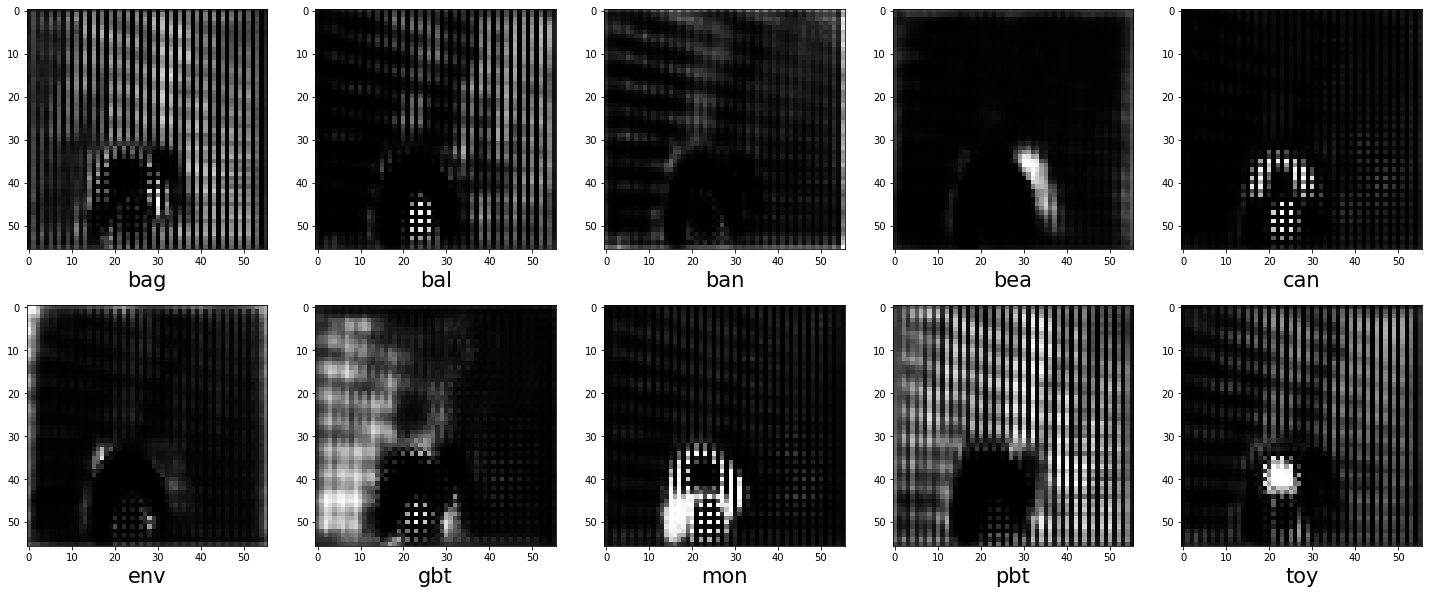

In [ ]:
# Show the result of prediction (one image for each class)
plt.figure(figsize=(25, 10)) # set size of the figure
for class_id in range(CLASS_COUNT): # for each class
    ax = plt.subplot(2, 5, class_id + 1) # draw space for axis
    plt.imshow(images[:,:,class_id]*255, cmap='gray') # draw image
    # ax.get_xaxis().set_visible(False) # hide axis x
    # ax.get_yaxis().set_visible(False) # hide axis y
    ax.set_xlabel(CLASS_LIST[class_id], fontsize=21) # set xlabel for current class
# clear_output(wait=True) # clear cell for output
# plt.savefig('image'+str(class_id)+'.jpg') # save ready figure to the file
plt.show() # output

In [ ]:
# Delete files in work directory
!rm -fv /content/*.jpg

# Callback function for on_epoch_end
def on_epoch_end(epoch, logs):
  img = np.random.uniform(0.0, 1.0, (IMG_WIDTH,IMG_HEIGHT,3)) # create image from noise
  # img = test_generator[0][0][0] # get image from test_generator
  pred = mymodel.predict(img[None,...]) # Prediction with the current state of traning
  images = np.squeeze(pred) # remove batch dimension
  # Show the result of prediction (one image for each class)
  plt.figure(figsize=(25, 10)) # set size of the figure
  for class_id in range(CLASS_COUNT): # for each class
      ax = plt.subplot(2, 5, class_id + 1) # draw space for axis
      plt.imshow(images[:,:,class_id]*255, cmap='gray') # draw image
      # ax.get_xaxis().set_visible(False) # hide axis x
      # ax.get_yaxis().set_visible(False) # hide axis y
      ax.set_xlabel(CLASS_LIST[class_id], fontsize=21) # set xlabel for current class
  # clear_output(wait=True) # clear cell for output
  plt.savefig('image'+str(epoch)+'.jpg') # save ready figure to the file
  plt.show() # output 
# Callbacks
early = EarlyStopping(monitor='val_loss', patience=10, mode='auto')
# lr_reduce = ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=0, mode='auto') 

# Callback for saving one figure for the each epoch
plt_img = LambdaCallback(on_epoch_end=on_epoch_end)

# Processing errors with truncated images
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Hyperparameters
BATCH_SIZE    = 256                        # Batch size for training
OPTIMIZER     = Adam(learning_rate=1e-6)  # Optimizer
EPOCHS        = 100                       # Epochs

# Model compilation
model.compile(loss='categorical_crossentropy', optimizer=OPTIMIZER, metrics=['accuracy'])

# Model train
history = model.fit(train_generator,
                    steps_per_epoch = train_generator.samples // BATCH_SIZE,
                    validation_data=validation_generator,
                    validation_steps = validation_generator.samples // BATCH_SIZE,
                    epochs=EPOCHS,
                    # batch_size=BATCH_SIZE,
                    callbacks=[plt_img,early]) #[early,checkpoint,lr_reduce,plt_img])

# Visualization of the training process
plt.plot(history.history['accuracy'], label='Part of the right answers on the training set')
plt.plot(history.history['val_accuracy'], label='Part of the right answers on the validation set')
plt.xlabel('Epoch of the training')
plt.ylabel('Part of the right answers')
plt.legend()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import imageio # Library imageio
images = [] # Empty list for gif

for i in range(61): # for each frame
    images.append(imageio.imread('image'+str(i)+'.jpg')) # Add next image in the list
imageio.mimsave('6_mymodelV3_dense512.gif', images) # .mimsave() saves the animation